# Tacotron2

* https://arxiv.org/abs/1712.05884

* Tacotron은 대표적인 Text To Speech 모델
* Tacotron 장점
  + 텍스트를 입력받아 바로 raw spectrogram 생성 가능
  + 간단하게 (text, audio) 쌍을 투입해 end-to-end 학습 가능

출처 - https://pytorch.org/hub/nvidia_deeplearningexamples_tacotron2/



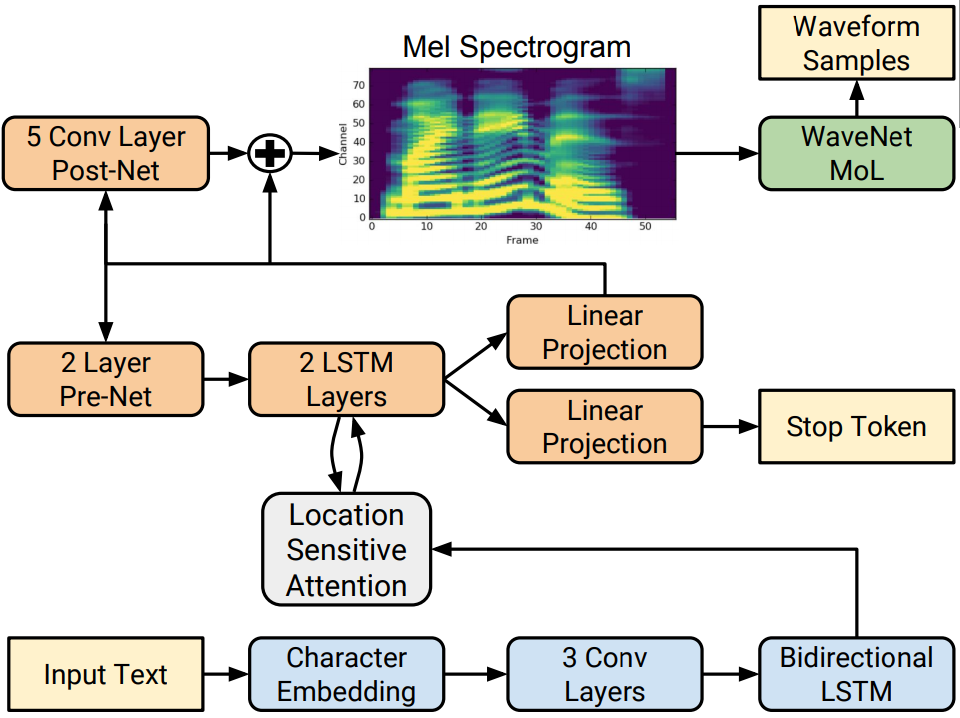

## 라이브러리 설치 및 학습 준비

*  tacotron 구현에는 pytorch와 torchaudio를 사용
*  해당 라이브러리를 설치하고 필요한 라이브러리를 추가

In [1]:
!pip install torch
!pip install torchaudio

     |████████████████████████████████| 6.7MB 4.9MB/s 


In [2]:
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from math import sqrt

import os
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import torchaudio
import numpy as np
import unicodedata
import re
import time

## 파라미터 설정 및 gpu 설정



*   파라미터를 일일이 설정해서 사용할 수도 있지만 유지보수면에선 좋지 않음
*   파라미터 관리용 클래스를 설정해 필요할 때마다 편리하게 수정하면 유지보수할 때 편리
*   tensorflow의 경우 자동으로 gpu를 잡아주지만, pytorch에서는 gpu 사용 여부를 설정해주어야 함



In [3]:
class HParams():
    def __init__(self):
        self.n_mel_channels = 80
        self.symbols_embedding_dim=256

        self.encoder_kernel_size=5
        self.encoder_n_convolutions=2
        self.encoder_embedding_dim=256

        self.n_frames_per_step=1
        self.decoder_rnn_dim=256
        self.prenet_dim=128
        self.max_decoder_steps=500
        self.gate_threshold=0.5
        self.p_attention_dropout=0.1
        self.p_decoder_dropout=0.1

        self.attention_rnn_dim=256
        self.attention_dim=128

        self.attention_location_n_filters=32
        self.attention_location_kernel_size=31

        self.postnet_embedding_dim=256
        self.postnet_kernel_size=5
        self.postnet_n_convolutions=5

        self.use_saved_learning_rate=False
        self.learning_rate=1e-3
        self.weight_decay=1e-6
        self.grad_clip_thresh=1.0
        self.batch_size=16
        self.mask_padding=True
    
    
hparams = HParams()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
  device = torch.device("cuda")
  print('GPU를 사용할 준비가 되었습니다.')
else:
  device = torch.device("cpu")
  print('CPU 모드입니다. GPU 설정으로 변경해주세요.')

GPU를 사용할 준비가 되었습니다.


## 데이터 준비 및 전처리

* 해당 예제에서는 LJSPEECH 데이터셋을 사용
* LJSPEECH 데이터셋은 7개의 책의 짧은 구문을 단일 화자가 말한 것을 나타내는 데이터셋
* 데이터셋을 다운받기 위해 url을 설정하고 torchaudio를 통해 다운로드
* https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2



In [4]:
LJSpeech_url = 'https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2'
train_dataset = torchaudio.datasets.LJSPEECH("", url=LJSpeech_url, download=True)

In [5]:
tt = []
for i in range(200):
  tt.append(train_dataset[i])
print(len(tt))

200




*   사용할 알파벳을 정의하고 사전을 만듬
*   text_normalize 함수를 통해 데이터를 소문자 통합, 정제 처리



In [6]:
vocab = " abcdefghijklmnopqrstuvwxyz'.?"  # P: Padding, E: EOS.
char2idx = {char: idx for idx, char in enumerate(vocab)}
idx2char = {idx: char for idx, char in enumerate(vocab)}


def text_normalize(text):
    text = ''.join(char for char in unicodedata.normalize('NFD', text)
                   if unicodedata.category(char) != 'Mn')  # Strip accents

    text = text.lower()
    text = re.sub("[^{}]".format(vocab), " ", text)
    text = re.sub("[ ]+", " ", text)
    return text

* 데이터를 편리하게 사용하기 위해 DataLoader 객체와 Collate 정의
* Collate는 DataLoader에 입력되는 데이터를 동일한 형상으로 맞춰주는 역할

In [7]:
class Collate():
  def __init__(self):
    self.wav_to_mel = torchaudio.transforms.MelSpectrogram(sample_rate=22050, n_mels=80, win_length=1024, hop_length=256, f_min=0.0, f_max=8000.0, n_fft=1024)

  def __call__(self, batch):
    # batch: N_batch * [wav, sample_rate, text, text_normalized]
    mel_list = []
    for data in batch:
      wav = data[0]
      mel_list.append(self.wav_to_mel(wav).squeeze())
    input_lengths, ids_sorted_decreasing = torch.sort(torch.LongTensor([len(data[3]) for data in batch]), dim=0, descending=True)
    mel_lengths, ids_sorted_mel = torch.sort(torch.LongTensor([mel.shape[1] for mel in mel_list]), dim=0, descending=True)

    max_input_len = input_lengths[0]
    max_target_len = mel_lengths[0]

    text_padded = torch.LongTensor(len(batch), max_input_len)
    mel_padded = torch.FloatTensor(len(batch), 80, max_target_len)
    gate_padded = torch.FloatTensor(len(batch), max_target_len)
    output_lengths = torch.LongTensor(len(batch))

    text_padded.zero_()
    mel_padded.zero_()
    gate_padded.zero_()

    for i in range(len(ids_sorted_decreasing)):
        _, _, _, text = batch[ids_sorted_decreasing[i]]
        mel = mel_list[ids_sorted_decreasing[i]]
        mel = self.dynamic_range_compression(mel)
        mel_padded[i, :, :mel.size(1)] = mel
        gate_padded[i, mel.size(1)-1:] = 1
        output_lengths[i] = mel.size(1)
        text = text_normalize(text)
        text = [char2idx[char] for char in text]
        text_norm = torch.IntTensor(text)
        text_padded[i, :len(text)] = text_norm

    return text_padded, input_lengths, mel_padded, gate_padded, output_lengths

  def dynamic_range_compression(self, x, C=1, clip_val=1e-5):
    return torch.log(torch.clamp(x, min=clip_val) * C)

In [8]:
collate_fn = Collate()
train_loader = DataLoader(tt, 
                          batch_size=hparams.batch_size, 
                          shuffle=True, drop_last=False, 
                          collate_fn=collate_fn)

## 모델 구성

In [9]:
def get_mask_from_lengths(lengths):
    max_len = torch.max(lengths).item()
    ids = torch.arange(0, max_len, out=torch.cuda.LongTensor(max_len))
    mask = (ids < lengths.unsqueeze(1)).bool()
    return mask


def to_gpu(x):
    x = x.contiguous()
    if torch.cuda.is_available():
        x = x.cuda(non_blocking=True)
    return torch.autograd.Variable(x)

## LinearNorm

* xavier 초기화 추가

In [10]:
class LinearNorm(torch.nn.Module):
  def __init__(self, in_dim, out_dim, bias=True, w_init_gain='linear'):
      super(LinearNorm, self).__init__()
      self.linear_layer = torch.nn.Linear(in_dim, out_dim, bias=bias)

      torch.nn.init.xavier_uniform_(
          self.linear_layer.weight,
          gain=torch.nn.init.calculate_gain(w_init_gain))

  def forward(self, x):
      return self.linear_layer(x)

## ConvNorm

* xavier 초기화 추가

In [11]:
class ConvNorm(torch.nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=1, stride=1,
                padding=None, dilation=1, bias=True, w_init_gain='linear'):
      super(ConvNorm, self).__init__()
      if padding is None:
          assert(kernel_size % 2 == 1)
          padding = int(dilation * (kernel_size - 1) / 2)

      self.conv = torch.nn.Conv1d(in_channels, out_channels,
                                  kernel_size=kernel_size, stride=stride,
                                  padding=padding, dilation=dilation,
                                  bias=bias)

      torch.nn.init.xavier_uniform_(
          self.conv.weight, gain=torch.nn.init.calculate_gain(w_init_gain))

  def forward(self, signal):
      conv_signal = self.conv(signal)
      return conv_signal

## Encoder


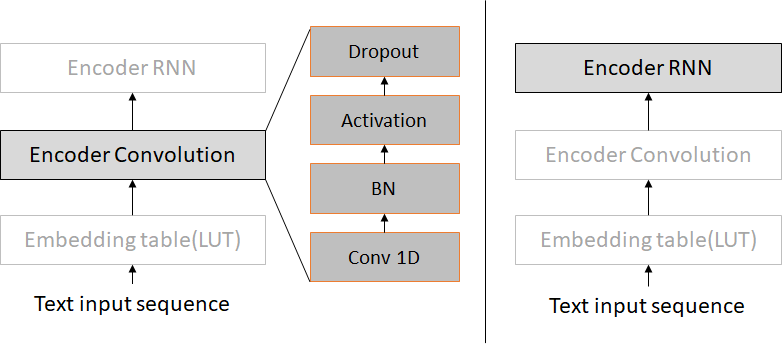



*   encoder의 구조는 그림과 같이 일반적인 convolution 연산 후 rnn을 거치는 구조
*   자연어 처리에 사용되는 encoder와 마찬가지로 sequence의 정보를 압축하는 역할



In [12]:
class Encoder(nn.Module):
  def __init__(self, hparams):
      super(Encoder, self).__init__()

      convolutions = []
      for _ in range(hparams.encoder_n_convolutions):
          conv_layer = nn.Sequential(
              ConvNorm(hparams.encoder_embedding_dim,
                        hparams.encoder_embedding_dim,
                        kernel_size=hparams.encoder_kernel_size, stride=1,
                        padding=int((hparams.encoder_kernel_size - 1) / 2),
                        dilation=1, w_init_gain='relu'),
              nn.BatchNorm1d(hparams.encoder_embedding_dim))
          convolutions.append(conv_layer)
      self.convolutions = nn.ModuleList(convolutions)

      self.lstm = nn.LSTM(hparams.encoder_embedding_dim,
                          int(hparams.encoder_embedding_dim / 2), 1,
                          batch_first=True, bidirectional=True)

  def forward(self, x, input_lengths):
      # encoder convolution
      for conv in self.convolutions:
          x = F.dropout(F.relu(conv(x)), 0.5, self.training)

      x = x.transpose(1, 2)

      # pytorch tensor are not reversible, hence the conversion
      input_lengths = input_lengths.cpu().numpy()
      x = nn.utils.rnn.pack_padded_sequence(
          x, input_lengths, batch_first=True) #병렬 처리를 위해 padded된 sequence들을 packing하는 과정, 일종의 길이에 따른 sorting 과정 더 빠른 연산 가능

      # encoder rnn
      self.lstm.flatten_parameters()
      outputs, _ = self.lstm(x)

      outputs, _ = nn.utils.rnn.pad_packed_sequence(
          outputs, batch_first=True)

      return outputs

  def inference(self, x):
      for conv in self.convolutions:
          x = F.dropout(F.relu(conv(x)), 0.5, self.training)

      x = x.transpose(1, 2)

      self.lstm.flatten_parameters()
      outputs, _ = self.lstm(x)

      return outputs

## Conventional Attention



*   자연어 처리와 동일하게 디코더에 인코더의 정보를 추가로 활용하기 위해 attention mechanism 사용
*   단 기존보다 위치에 신경쓰도록 위치 정보를 어텐션 계산 때 추가
*   사용된 attention mechanism에 대한 수식은 다음과 같음




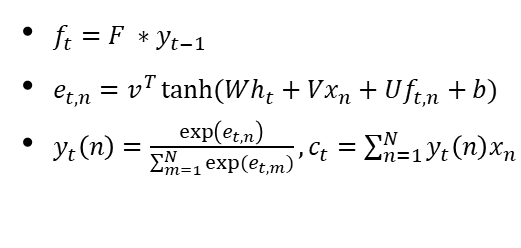

*   위의 식에서 각 항목이 의미하는 것은 다음과 같음
    *  $x$ - text embedding sequence
    *  $h$ - decoder lstm sequence
    *  $y$ - location
*  $e_{t,n}$ 계산 수식에서 $Wh_t, Vx_n$은 입력에 관한 정보, $Uf_{t,n}$은 위치에 관한 정보를 나타냄
*  이는 attention을 계산할 때 기존보다 위치 정보에 좀 더 신경쓰는 것을 의미
*   각 수식을 기존 attention mechanism에 대입하면 다음과 같음
    *   $f_t$ - 어텐션 스코어 계산
    *   $e_{t,n}$, $y_t(n)$ - 어텐션 분포 계산
    *   $c_t$ - 어텐션 값 계산



### LocationLayer

In [13]:
class LocationLayer(nn.Module):
  def __init__(self, attention_n_filters, attention_kernel_size,
                attention_dim):
      super(LocationLayer, self).__init__()
      padding = int((attention_kernel_size - 1) / 2)
      self.location_conv = ConvNorm(2, attention_n_filters,
                                    kernel_size=attention_kernel_size,
                                    padding=padding, bias=False, stride=1,
                                    dilation=1)
      self.location_dense = LinearNorm(attention_n_filters, attention_dim,
                                        bias=False, w_init_gain='tanh')

  def forward(self, attention_weights_cat):
      processed_attention = self.location_conv(attention_weights_cat)
      processed_attention = processed_attention.transpose(1, 2)
      processed_attention = self.location_dense(processed_attention)
      return processed_attention

### Attention

In [14]:
class Attention(nn.Module):
  def __init__(self, attention_rnn_dim, embedding_dim, attention_dim,
                attention_location_n_filters, attention_location_kernel_size):
      super(Attention, self).__init__()
      self.query_layer = LinearNorm(attention_rnn_dim, attention_dim,
                                    bias=False, w_init_gain='tanh')
      self.memory_layer = LinearNorm(embedding_dim, attention_dim, bias=False,
                                      w_init_gain='tanh')
      self.v = LinearNorm(attention_dim, 1, bias=False)
      self.location_layer = LocationLayer(attention_location_n_filters,
                                          attention_location_kernel_size,
                                          attention_dim)
      self.score_mask_value = -float("inf")

  def get_alignment_energies(self, query, processed_memory,
                              attention_weights_cat):
      processed_query = self.query_layer(query.unsqueeze(1))
      processed_attention_weights = self.location_layer(attention_weights_cat)
      energies = self.v(torch.tanh(
          processed_query + processed_attention_weights + processed_memory))

      energies = energies.squeeze(-1)
      return energies

  def forward(self, attention_hidden_state, memory, processed_memory,
              attention_weights_cat, mask):
      alignment = self.get_alignment_energies(
          attention_hidden_state, processed_memory, attention_weights_cat)

      if mask is not None:
          alignment.data.masked_fill_(mask, self.score_mask_value)

      attention_weights = F.softmax(alignment, dim=1)
      attention_context = torch.bmm(attention_weights.unsqueeze(1), memory) # bmm: batch matrix multiplication
      attention_context = attention_context.squeeze(1)

      return attention_context, attention_weights

## Decoder

* Prenet은 linear layer들로 이루어져 있으며, 수렴과 일반화 역할을 함
* Postnet은 conv layer들로 이루어져 있으며, residual and skip connection 구조도 확인할 수 있음




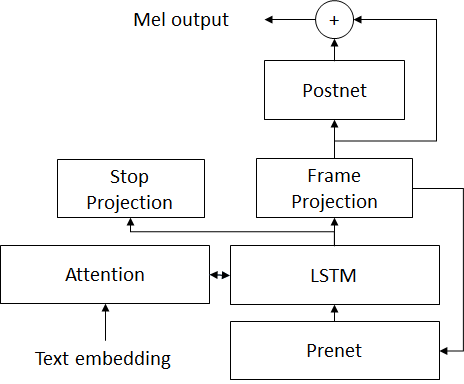

### Prenet

In [15]:
class Prenet(nn.Module):
  def __init__(self, in_dim, sizes):
      super(Prenet, self).__init__()
      in_sizes = [in_dim] + sizes[:-1]
      self.layers = nn.ModuleList(
          [LinearNorm(in_size, out_size, bias=False)
            for (in_size, out_size) in zip(in_sizes, sizes)])

  def forward(self, x):
      for linear in self.layers:
          x = F.dropout(F.relu(linear(x)), p=0.5, training=True)
      return x

### Postnet

In [16]:
class Postnet(nn.Module):
  def __init__(self, hparams):
      super(Postnet, self).__init__()
      self.convolutions = nn.ModuleList()

      self.convolutions.append(
          nn.Sequential(
              ConvNorm(hparams.n_mel_channels, hparams.postnet_embedding_dim,
                        kernel_size=hparams.postnet_kernel_size, stride=1,
                        padding=int((hparams.postnet_kernel_size - 1) / 2),
                        dilation=1, w_init_gain='tanh'),
              nn.BatchNorm1d(hparams.postnet_embedding_dim))
      )

      for i in range(1, hparams.postnet_n_convolutions - 1):
          self.convolutions.append(
              nn.Sequential(
                  ConvNorm(hparams.postnet_embedding_dim,
                            hparams.postnet_embedding_dim,
                            kernel_size=hparams.postnet_kernel_size, stride=1,
                            padding=int((hparams.postnet_kernel_size - 1) / 2),
                            dilation=1, w_init_gain='tanh'),
                  nn.BatchNorm1d(hparams.postnet_embedding_dim))
          )

      self.convolutions.append(
          nn.Sequential(
              ConvNorm(hparams.postnet_embedding_dim, hparams.n_mel_channels,
                        kernel_size=hparams.postnet_kernel_size, stride=1,
                        padding=int((hparams.postnet_kernel_size - 1) / 2),
                        dilation=1, w_init_gain='linear'),
              nn.BatchNorm1d(hparams.n_mel_channels))
          )

  def forward(self, x):
      for i in range(len(self.convolutions) - 1):
          x = F.dropout(torch.tanh(self.convolutions[i](x)), 0.5, self.training)
      x = F.dropout(self.convolutions[-1](x), 0.5, self.training)

      return x

In [17]:
class Decoder(nn.Module):
  def __init__(self, hparams):
      super(Decoder, self).__init__()
      self.n_mel_channels = hparams.n_mel_channels
      self.n_frames_per_step = hparams.n_frames_per_step
      self.encoder_embedding_dim = hparams.encoder_embedding_dim
      self.attention_rnn_dim = hparams.attention_rnn_dim
      self.decoder_rnn_dim = hparams.decoder_rnn_dim
      self.prenet_dim = hparams.prenet_dim
      self.max_decoder_steps = hparams.max_decoder_steps
      self.gate_threshold = hparams.gate_threshold
      self.p_attention_dropout = hparams.p_attention_dropout
      self.p_decoder_dropout = hparams.p_decoder_dropout

      self.prenet = Prenet(
          hparams.n_mel_channels * hparams.n_frames_per_step,
          [hparams.prenet_dim, hparams.prenet_dim])

      self.attention_rnn = nn.LSTMCell(
          hparams.prenet_dim + hparams.encoder_embedding_dim,
          hparams.attention_rnn_dim)

      self.attention_layer = Attention(
          hparams.attention_rnn_dim, hparams.encoder_embedding_dim,
          hparams.attention_dim, hparams.attention_location_n_filters,
          hparams.attention_location_kernel_size)

      self.decoder_rnn = nn.LSTMCell(
          hparams.attention_rnn_dim + hparams.encoder_embedding_dim,
          hparams.decoder_rnn_dim, 1)

      self.linear_projection = LinearNorm(
          hparams.decoder_rnn_dim + hparams.encoder_embedding_dim,
          hparams.n_mel_channels * hparams.n_frames_per_step)

      self.gate_layer = LinearNorm(
          hparams.decoder_rnn_dim + hparams.encoder_embedding_dim, 1,
          bias=True, w_init_gain='sigmoid')

  def get_go_frame(self, memory):
      B = memory.size(0)
      decoder_input = Variable(memory.data.new(
          B, self.n_mel_channels * self.n_frames_per_step).zero_())
      return decoder_input

  def initialize_decoder_states(self, memory, mask):
      B = memory.size(0)
      MAX_TIME = memory.size(1)

      self.attention_hidden = Variable(memory.data.new(
          B, self.attention_rnn_dim).zero_())
      self.attention_cell = Variable(memory.data.new(
          B, self.attention_rnn_dim).zero_())

      self.decoder_hidden = Variable(memory.data.new(
          B, self.decoder_rnn_dim).zero_())
      self.decoder_cell = Variable(memory.data.new(
          B, self.decoder_rnn_dim).zero_())

      self.attention_weights = Variable(memory.data.new(
          B, MAX_TIME).zero_())
      self.attention_weights_cum = Variable(memory.data.new(
          B, MAX_TIME).zero_())
      self.attention_context = Variable(memory.data.new(
          B, self.encoder_embedding_dim).zero_())

      self.memory = memory
      self.processed_memory = self.attention_layer.memory_layer(memory)
      self.mask = mask

  def parse_decoder_inputs(self, decoder_inputs):
      # (B, n_mel_channels, T_out) -> (B, T_out, n_mel_channels)
      decoder_inputs = decoder_inputs.transpose(1, 2)
      decoder_inputs = decoder_inputs.view(
          decoder_inputs.size(0),
          int(decoder_inputs.size(1)/self.n_frames_per_step), -1)
      # (B, T_out, n_mel_channels) -> (T_out, B, n_mel_channels)
      decoder_inputs = decoder_inputs.transpose(0, 1)
      return decoder_inputs

  def parse_decoder_outputs(self, mel_outputs, gate_outputs, alignments):
      # (T_out, B) -> (B, T_out)
      alignments = torch.stack(alignments).transpose(0, 1)
      # (T_out, B) -> (B, T_out)
      gate_outputs = torch.stack(gate_outputs).transpose(0, 1)
      gate_outputs = gate_outputs.contiguous()
      # (T_out, B, n_mel_channels) -> (B, T_out, n_mel_channels)
      mel_outputs = torch.stack(mel_outputs).transpose(0, 1).contiguous()
      # decouple frames per step
      mel_outputs = mel_outputs.view(
          mel_outputs.size(0), -1, self.n_mel_channels)
      # (B, T_out, n_mel_channels) -> (B, n_mel_channels, T_out)
      mel_outputs = mel_outputs.transpose(1, 2)

      return mel_outputs, gate_outputs, alignments

  def decode(self, decoder_input):
      cell_input = torch.cat((decoder_input, self.attention_context), -1)
      self.attention_hidden, self.attention_cell = self.attention_rnn(
          cell_input, (self.attention_hidden, self.attention_cell))
      self.attention_hidden = F.dropout(
          self.attention_hidden, self.p_attention_dropout, self.training)

      attention_weights_cat = torch.cat(
          (self.attention_weights.unsqueeze(1),
            self.attention_weights_cum.unsqueeze(1)), dim=1)
      self.attention_context, self.attention_weights = self.attention_layer(
          self.attention_hidden, self.memory, self.processed_memory,
          attention_weights_cat, self.mask) 

      self.attention_weights_cum += self.attention_weights
      decoder_input = torch.cat(
          (self.attention_hidden, self.attention_context), -1)
      self.decoder_hidden, self.decoder_cell = self.decoder_rnn(
          decoder_input, (self.decoder_hidden, self.decoder_cell))
      self.decoder_hidden = F.dropout(
          self.decoder_hidden, self.p_decoder_dropout, self.training)

      decoder_hidden_attention_context = torch.cat(
          (self.decoder_hidden, self.attention_context), dim=1)
      decoder_output = self.linear_projection(
          decoder_hidden_attention_context)

      gate_prediction = self.gate_layer(decoder_hidden_attention_context)
      return decoder_output, gate_prediction, self.attention_weights

  def forward(self, memory, decoder_inputs, memory_lengths):
      decoder_input = self.get_go_frame(memory).unsqueeze(0)
      decoder_inputs = self.parse_decoder_inputs(decoder_inputs)
      decoder_inputs = torch.cat((decoder_input, decoder_inputs), dim=0)
      decoder_inputs = self.prenet(decoder_inputs)

      self.initialize_decoder_states(
          memory, mask=~get_mask_from_lengths(memory_lengths))

      mel_outputs, gate_outputs, alignments = [], [], []
      while len(mel_outputs) < decoder_inputs.size(0) - 1:
          decoder_input = decoder_inputs[len(mel_outputs)]
          mel_output, gate_output, attention_weights = self.decode(
              decoder_input)
          mel_outputs += [mel_output.squeeze(1)]
          gate_outputs += [gate_output.squeeze(1)]
          alignments += [attention_weights]

      mel_outputs, gate_outputs, alignments = self.parse_decoder_outputs(
          mel_outputs, gate_outputs, alignments)

      return mel_outputs, gate_outputs, alignments

  def inference(self, memory):
      decoder_input = self.get_go_frame(memory)

      self.initialize_decoder_states(memory, mask=None)

      mel_outputs, gate_outputs, alignments = [], [], []
      while True: #free learning 모드
          decoder_input = self.prenet(decoder_input)
          mel_output, gate_output, alignment = self.decode(decoder_input)

          mel_outputs += [mel_output.squeeze(1)]
          gate_outputs += [gate_output]
          alignments += [alignment]

          if torch.sigmoid(gate_output.data) > self.gate_threshold:
              break
          elif len(mel_outputs) == self.max_decoder_steps:
              print("Warning! Reached max decoder steps")
              break

          decoder_input = mel_output

      mel_outputs, gate_outputs, alignments = self.parse_decoder_outputs(
          mel_outputs, gate_outputs, alignments)

      return mel_outputs, gate_outputs, alignments

## Tacotron2

* 최종적으로 tacotron 모델 구성



In [18]:
class Tacotron2(nn.Module):
  def __init__(self, hparams):
      super(Tacotron2, self).__init__()
      self.mask_padding = hparams.mask_padding
      self.n_mel_channels = hparams.n_mel_channels
      self.n_frames_per_step = hparams.n_frames_per_step
      self.embedding = nn.Embedding(len(vocab), hparams.symbols_embedding_dim)
      std = sqrt(2.0 / (len(vocab) + hparams.symbols_embedding_dim))
      val = sqrt(3.0) * std  # uniform bounds for std
      self.embedding.weight.data.uniform_(-val, val)
      self.encoder = Encoder(hparams)
      self.decoder = Decoder(hparams)
      self.postnet = Postnet(hparams)

  def parse_batch(self, batch):
      text_padded, input_lengths, mel_padded, gate_padded, \
          output_lengths = batch
      text_padded = to_gpu(text_padded).long()
      input_lengths = to_gpu(input_lengths).long()
      max_len = torch.max(input_lengths.data).item()
      mel_padded = to_gpu(mel_padded).float()
      gate_padded = to_gpu(gate_padded).float()
      output_lengths = to_gpu(output_lengths).long()

      return (
          (text_padded, input_lengths, mel_padded, max_len, output_lengths),
          (mel_padded, gate_padded))

  def parse_output(self, outputs, output_lengths=None):
      if self.mask_padding and output_lengths is not None:
          mask = ~get_mask_from_lengths(output_lengths)
          mask = mask.expand(self.n_mel_channels, mask.size(0), mask.size(1))
          mask = mask.permute(1, 0, 2)

          outputs[0].data.masked_fill_(mask, 0.0)
          outputs[1].data.masked_fill_(mask, 0.0)
          outputs[2].data.masked_fill_(mask[:, 0, :], 1e3)  # gate energies

      return outputs

  def forward(self, inputs):
      text_inputs, text_lengths, mels, max_len, output_lengths = inputs
      text_lengths, output_lengths = text_lengths.data, output_lengths.data

      embedded_inputs = self.embedding(text_inputs).transpose(1, 2) #LUT

      encoder_outputs = self.encoder(embedded_inputs, text_lengths)

      mel_outputs, gate_outputs, alignments = self.decoder(encoder_outputs, mels, memory_lengths=text_lengths)

      mel_outputs_postnet = self.postnet(mel_outputs)
      mel_outputs_postnet = mel_outputs + mel_outputs_postnet

      return self.parse_output(
          [mel_outputs, mel_outputs_postnet, gate_outputs, alignments],
          output_lengths)

  def inference(self, inputs):
      embedded_inputs = self.embedding(inputs).transpose(1, 2)
      encoder_outputs = self.encoder.inference(embedded_inputs)
      mel_outputs, gate_outputs, alignments = self.decoder.inference(encoder_outputs)

      mel_outputs_postnet = self.postnet(mel_outputs)
      mel_outputs_postnet = mel_outputs + mel_ouftputs_postnet

      outputs = self.parse_output([mel_outputs, mel_outputs_postnet, gate_outputs, alignments])

      return outputs

## 모델 학습



*   작성한 코드를 바탕으로 모델, 학습률, optimizer, 손실 함수를 정의



In [19]:
model = Tacotron2(hparams).to(device)
learning_rate = hparams.learning_rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                              weight_decay=hparams.weight_decay)

#### Tacotron2Loss

In [20]:
class Tacotron2Loss(nn.Module):
  def __init__(self):
      super(Tacotron2Loss, self).__init__()

  def forward(self, model_output, targets):
      mel_target, gate_target = targets[0], targets[1]
      mel_target.requires_grad = False
      gate_target.requires_grad = False
      gate_target = gate_target.view(-1, 1)

      mel_out, mel_out_postnet, gate_out, _ = model_output
      gate_out = gate_out.view(-1, 1)
      mel_loss = nn.MSELoss()(mel_out, mel_target) + nn.MSELoss()(mel_out_postnet, mel_target)
      gate_loss = nn.BCEWithLogitsLoss()(gate_out, gate_target)
      return mel_loss + gate_loss

criterion = Tacotron2Loss()



*   모델 학습을 진행



In [21]:
iteration = 0

for epoch in range(20):
  print("Epoch: {}".format(epoch))
  for i, batch in enumerate(train_loader):
    start = time.perf_counter()
    model.zero_grad()
    x, y = model.parse_batch(batch)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    reduced_loss = loss.item()  #[1.0] -> 1.0
    loss.backward()
    grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), hparams.grad_clip_thresh)

    optimizer.step()

    duration = time.perf_counter() - start
    print("Train loss {} {:.6f} Grad Norm {:.6f} {:.2f}s/it".format(
        iteration, reduced_loss, grad_norm, duration))
    
    iteration += 1

Epoch: 0
Train loss 0 37.957127 Grad Norm 5.100497 3.50s/it
Train loss 1 36.269405 Grad Norm 6.856381 2.95s/it
Train loss 2 35.473492 Grad Norm 6.354650 2.89s/it
Train loss 3 31.237167 Grad Norm 6.871250 3.28s/it
Train loss 4 25.830875 Grad Norm 6.809653 3.21s/it
Train loss 5 21.033741 Grad Norm 6.036325 3.08s/it
Train loss 6 20.316689 Grad Norm 6.384245 3.14s/it
Train loss 7 22.103727 Grad Norm 7.896470 3.19s/it
Train loss 8 19.585354 Grad Norm 6.663923 2.95s/it
Train loss 9 16.699448 Grad Norm 6.144726 3.23s/it
Train loss 10 15.363336 Grad Norm 4.799792 3.16s/it
Train loss 11 15.628259 Grad Norm 3.579868 3.25s/it
Train loss 12 14.708182 Grad Norm 3.205776 2.82s/it
Epoch: 1
Train loss 13 16.007624 Grad Norm 3.273052 3.25s/it
Train loss 14 16.544701 Grad Norm 4.030401 2.66s/it
Train loss 15 14.713122 Grad Norm 2.755015 3.17s/it
Train loss 16 13.296306 Grad Norm 3.580583 3.07s/it
Train loss 17 16.913055 Grad Norm 3.529567 3.22s/it
Train loss 18 15.375027 Grad Norm 2.824532 2.91s/it
Trai

## 모델 실행

In [22]:
!pip uninstall librosa

Uninstalling librosa-0.6.3:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/librosa-0.6.3.dist-info/*
    /usr/local/lib/python3.6/dist-packages/librosa/*
Proceed (y/n)? y
  Successfully uninstalled librosa-0.6.3


In [23]:
!pip install librosa==0.8.0

     |████████████████████████████████| 184kB 7.3MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
  Created wheel for librosa: filename=librosa-0.8.0-cp36-none-any.whl size=201376 sha256=157eaba59888a39d8e71fd4bf2769b546091cb8dafe8942319db95722a5a4d92
  Stored in directory: /root/.cache/pip/wheels/ee/10/1e/382bb4369e189938d5c02e06d10c651817da8d485bfd1647c9
Successfully built librosa


In [24]:
import librosa
for i, batch in enumerate(train_loader):
    x, y = model.parse_batch(batch)
    y_pred = model(x)
    break

tt = np.array(y_pred[0].cpu().detach().numpy())
print(tt.shape)
aaa = []

a1 = tt.shape[1]
a2 = tt.shape[2]
for i in tt:
  i = i.reshape(a1, a2)
aaa.append(librosa.feature.inverse.mel_to_audio(i))

(16, 80, 860)


In [25]:
import soundfile as sf

aaa = np.array(aaa)
aaa = aaa.reshape((aaa.shape[1], aaa.shape[0]))
sf.write('./tt1.wav', aaa, 22050, format = 'wav')

import IPython.display as ipd

ipd.Audio('tt1.wav')